## Convert yolo.txt annotation to json image format

In [77]:
import os
import cv2
import json
import numpy as np

with open('/home/minshiu/aws-lauretta-sagemaker-XRAY/XRaySamples/classes.txt', 'r') as ff:
    classes = ff.readlines()
classes = [c[:-1] for c in classes]

for file in filels:
    with open(file, 'r') as f:
        lines = f.readlines()
    imgf = file[:file.rfind('.')] + '.png'
    img = cv2.imread(imgf)
    height, width, depth = img.shape
    d = dict()
    d['image_size'] = [{'width': width, 'height': height, 'depth': 3}]
    d['file'] = imgf.split('/')[-1]
    annotation_ls = list()
    class_ls = list()
    class_ids = list()
    for l in lines:
        class_id, x, y, absw, absh = l[:-1].split(' ')
        #print(class_id, x, y, absw, absh)
        #print(float(x)*width, float(y)*height, float(absw)*width, float(absh)*height)
        xc = float(x)*width
        yc = float(y)*height
        w = float(absw)*width
        h = float(absh)*height
        left = xc - w/2
        top = yc - h/2
        #print(left, top, w, h)
        ann = {'left': int(left), 'top': int(top), 'width': int(w), 'height': int(h), 'class_id': class_id}
        annotation_ls.append(ann)
        if class_id not in class_ids:
            cls = {'class_id': class_id, 'name': classes[int(class_id)]}
            class_ls.append(cls)
            class_ids.append(class_id)
        #cv2.imshow('test', img[394:394+413, 1114:1114+71])
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
    d['annotations'] = annotation_ls
    d['categories'] = class_ls
    with open(imgf[:imgf.rfind('.')] + '.json', 'w') as p:
        json.dump(d, p)

## Convert labelbox json annotation to sagemaker json annotation

In [ ]:
## input: .json file(generated from labelbox export)
## output: one json file for one image

import os
import cv2
import json
import numpy as np

count = 0
synset_path = '/home/minshiu/aws-lauretta-sagemaker-XRAY/classes.txt'
with open(synset_path, 'r') as f:
    lines = f.readlines()
classes = [l[:-1] for l in lines]

number = np.arange(len(classes))
reference_list = dict(zip(classes, number))

file = '/home/minshiu/Downloads/export-2019-04-08T08_44_06.612Z.json'
with open(file, 'r') as f:
    lines = f.readlines()

raw_string = lines[0].split('"ID"')
del raw_string[0]
splitted = []

for idx, l in enumerate(raw_string):
    s = '''{"ID"''' + l[:-2]
    if int(idx) == len(raw_string) - 1:
        s += '}'
    splitted.append(json.loads(s))

for idx, item in enumerate(splitted):
    
    file = item.pop('External ID')
    filePath = '/home/minshiu/aws-lauretta-sagemaker-XRAY/' + file
    img = cv2.imread(filePath)
    
    if img is None:
        #print('Skipping file: {} \nReason: image not found'.format(file))
        continue
    
    print('Found image with annotation: {}'.format(file))
    
    (height, width, depth) = img.shape
    item['image_size'] = [{'width':width, 'height':height, 'depth':depth}]
    item['file'] = file
    ann_ls = []
    categories = []
    if item['Label'] != 'Skip':
        lbl = item['Label']
        for k in list(lbl.keys()):
            dct = lbl[k]
            for d in dct:
                ann = {}
                cls_name = list(d.values())[0]
                large_y = max(t['y'] for t in d['geometry'])
                small_y = min(t['y'] for t in d['geometry'])
                large_x = max(t['x'] for t in d['geometry'])
                small_x = min(t['x'] for t in d['geometry'])
                ann['left'] = small_x
                ann['top'] = small_y
                ann['width'] = large_x - small_x
                ann['height'] = large_y - small_y
                if type(cls_name) != list:
                    if cls_name not in reference_list.keys():
                        reference_list[cls_name] = str(len(reference_list))
                    ann['class_id'] = reference_list[cls_name]
                else:
                    if k not in reference_list.keys():
                        reference_list[k] = str(len(reference_list))
                    ann['class_id'] = reference_list[k]
                ann_ls.append(ann)

        item["annotations"] = ann_ls
        x = [ids['class_id'] for ids in ann_ls]
        unique = np.unique(x)
        for u in unique:
            k = [key for key in reference_list.items() if key[1] == str(u)][0][0]
            categories.append({"class_id": u, "name": k})
        item["categories"] = categories
    count += 1
    print(item, '\n')
    print('------------------------Done {} files.------------------------------'.format(count))
    
    keys = list(item.keys())[-4:]
    content = dict(zip([k for k in keys], [item[k] for k in keys]))
    jsonFile = item['file'].split('.')[0] + '.json'
    with open(os.path.join('/home/minshiu/aws-lauretta-sagemaker-XRAY/generated/', jsonFile), 'w') as p:
        json.dump(content, p)

In [33]:
reference_list ## Current detection list!

{'Electronic': 14,
 'Liquid': 17,
 'Opaque': 16,
 'Personal Item': 9,
 'cartridges': '19',
 'guns': 15,
 'handphone': 3,
 'key': 0,
 'knife': 6,
 'laptop': 8,
 'metal_pipes': 18,
 'other': 5,
 'other_electronic': 1,
 'other_item': 13,
 'other_liquid': 11,
 'other_weapon': 10,
 'powerbank': 7,
 'rifles': '20',
 'scissors': 12,
 'umbrella': 4,
 'water_bottle': 2}

## Configuration of mxnet model to make it deployable when offline

In [3]:
import mxnet as mx
import numpy as np

# **model shd be at deployment mode
network_prefix = '/home/minshiu/aws-lauretta-sagemaker-XRAY/model/detector3'
label_names = ['label']

# Load the network parameters from default epoch 0
sym, arg_params, aux_params = mx.model.load_checkpoint(network_prefix, 0)

# Load the network into an MXNet module and bind the corresponding parameters
mod = mx.mod.Module(symbol=sym, label_names=label_names, context=mx.gpu(0))
mod.bind(for_training=False, data_shapes=[('data', (1,3,512,512))])
mod.set_params(arg_params, aux_params)

/home/minshiu/anaconda3/lib/python3.6/site-packages/mxnet/module/base_module.py:54: UserWarning: You created Module with Module(..., label_names=['label']) but input with name 'label' is not found in symbol.list_arguments(). Did you mean one of:
	relu4_3_scale
	data
  warnings.warn(msg)
/home/minshiu/anaconda3/lib/python3.6/site-packages/mxnet/module/base_module.py:66: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['label'])
  warnings.warn(msg)


## Deploy mxnet model locally and make prediction

(1, 3, 512, 512)


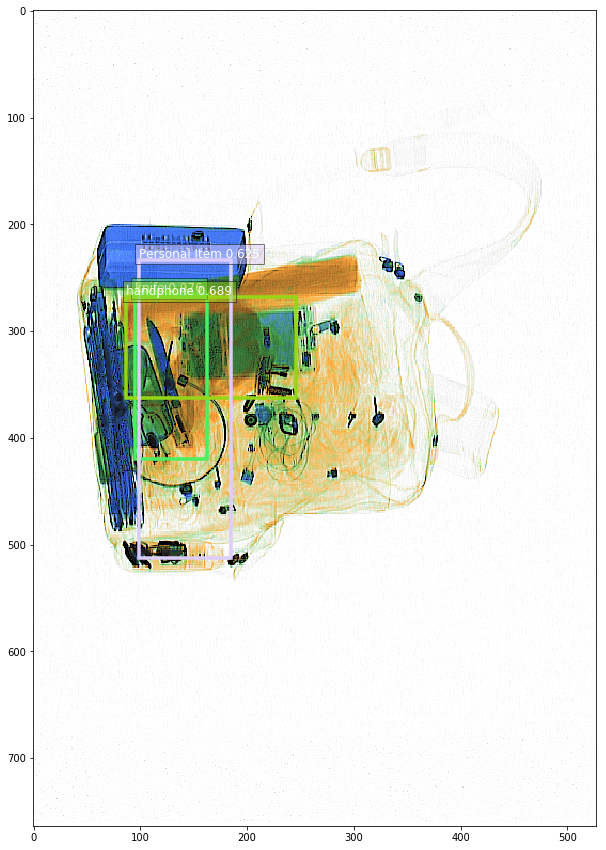

In [15]:
%matplotlib inline
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import namedtuple

Batch = namedtuple('Batch', ['data'])
img_file = '/home/minshiu/aws-lauretta-sagemaker-XRAY/train_weapon/6151655_20190106120056765_SCREENER.PNG'
img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,512))
img = np.swapaxes(img, 0, 2)
img = np.swapaxes(img, 1, 2)
img = img[np.newaxis, :]

# Run forward on the image
mod.forward(Batch([mx.nd.array(img)]))
prob = mod.get_outputs()[0].asnumpy()
prob = np.squeeze(prob)

plt.rcParams['figure.figsize'] = [15, 15]

synset_path = '/home/minshiu/aws-lauretta-sagemaker-XRAY/classes.txt'
with open(synset_path, 'r') as f:
    lines = f.readlines()
classes = [l[:-1] for l in lines]

img = mpimg.imread(img_file)
plt.imshow(img)
height = img.shape[0]
width = img.shape[1]
colors = dict()
for det in prob:
    (klass, score, x0, y0, x1, y1) = det
    if klass == -1:
        continue
    if score < 0.5:
        break
    cls_id = int(klass)
    if cls_id not in colors:
        colors[cls_id] = (random.random(), random.random(), random.random())
    xmin = int(x0 * width)
    ymin = int(y0 * height)
    xmax = int(x1 * width)
    ymax = int(y1 * height)
    rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                         ymax - ymin, fill=False,
                         edgecolor=colors[cls_id],
                         linewidth=3.5)
    class_name = classes[cls_id]
    plt.gca().add_patch(rect)
    plt.gca().text(xmin, ymin - 2,
                    '{:s} {:.3f}'.format(class_name, score),
                    bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                            fontsize=12, color='white')

## Stream and return prediction using socket

In [19]:
import cv2
import time
import json
import base64
import pickle
import socketio
import mxnet as mx
import numpy as np
from collections import namedtuple

def handleBoundaries(val, maxval):
    return 0 if val < 0 else int(maxval) if val > maxval else val

# standard Python
sio = socketio.Client()

sio.connect('http://192.168.1.49:3000')
synset_path = '/home/minshiu/aws-lauretta-sagemaker-XRAY/classes.txt'
with open(synset_path, 'r') as f:
    lines = f.readlines()
classes = [l[:-1] for l in lines]

# **model shd be at deployment mode
network_prefix = '/home/minshiu/aws-lauretta-sagemaker-XRAY/model/detector3'
label_names = ['label']

# Load the network parameters from default epoch 0
sym, arg_params, aux_params = mx.model.load_checkpoint(network_prefix, 0)

# Load the network into an MXNet module and bind the corresponding parameters
mod = mx.mod.Module(symbol=sym, label_names=label_names, context=mx.gpu(0))
mod.bind(for_training=False, data_shapes=[('data', (1,3,512,512))])
mod.set_params(arg_params, aux_params)
Batch = namedtuple('Batch', ['data'])

vid = cv2.VideoCapture('/home/minshiu/Downloads/video.mp4')
frame_skipping = 1
current_time = time.time()

while True:
    
    ret, frame = vid.read()
    
    if not ret:
        break
    
    height, width, _ = frame.shape
    if time.time() - current_time > frame_skipping:
        current_time = time.time() 
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512,512))
        img = np.swapaxes(img, 0, 2)
        img = np.swapaxes(img, 1, 2)
        img = img[np.newaxis, :]
        print('Results:')

        mod.forward(Batch([mx.nd.array(img)]))
        prob = mod.get_outputs()[0].asnumpy()
        prob = np.squeeze(prob)
        
        predictions = list()
        for det in prob:
            (klass, score, x1, y1, x2, y2) = det
            if klass == -1:
                continue
            if score < 0.5:
                break
            class_name = classes[int(klass)]
            
            xmin = handleBoundaries(int(x1*width)-30, width) 
            ymin = handleBoundaries(int(y1*height)-30, height)
            xmax = handleBoundaries(int(x2*width)+30, width) 
            ymax = handleBoundaries(int(y2*height)+30, height)
            
            detected_frame = frame[ymin:ymax, xmin:xmax]
            retval, buffer = cv2.imencode('.jpg', detected_frame)
            jpg_as_text = base64.b64encode(buffer)
            print(class_name, score)
            #sio.emit('message', data=(class_name, str(int(round(score*100))), 'hehe'))  
            sio.emit('data', data={'weapon': class_name, 'percentage': str(int(round(score*100))),
                                      'img':jpg_as_text.decode()})    


sio.disconnect()
vid.release()

/home/minshiu/anaconda3/lib/python3.6/site-packages/mxnet/module/base_module.py:54: UserWarning: You created Module with Module(..., label_names=['label']) but input with name 'label' is not found in symbol.list_arguments(). Did you mean one of:
	relu4_3_scale
	data
  warnings.warn(msg)
/home/minshiu/anaconda3/lib/python3.6/site-packages/mxnet/module/base_module.py:66: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['label'])
  warnings.warn(msg)


Results:
knife 0.95747936
guns 0.8671569
knife 0.77405477
Results:
knife 0.9631424
guns 0.86876416
knife 0.777125
Results:
knife 0.9571088
guns 0.86009365
knife 0.7680607
Results:
knife 0.95186305
guns 0.86306185
knife 0.7765435
Results:
knife 0.95995
guns 0.86362964
knife 0.7742827
Results:
guns 0.9609103
knife 0.9360458
knife 0.8116326
